In [ ]:
'''

'''

In [ ]:
'''
    - NLTK -- for tokenezing russian texts of election programs
    
    - (LINK!!) -- for creating matrix of program_x_term
    - sklearn -- for clustering...
'''

In [82]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# 0. Pre-defining functions

In [2]:
# to find n-th occurance of substring in the string (n = 0,1...)

def find_substring(txt, str1, n):
    parts = txt.split(str1, n + 1)
    if len(parts) <= n + 1:
        return -1
    return len(txt) - len(parts[-1]) - len(str1)

In [3]:
programs_df = pd.read_csv('../library: main/ssmm_elections_candidates_1_11.csv', sep='\t', encoding='utf-8')
programs_df = programs_df[['conv_x_name','name','program_txt','convocation_no']][programs_df['program_txt'].notna()].reset_index().drop(['index'],axis=1)
programs_df.head()


,conv_x_name,name,program_txt,convocation_no
0,1_Левин_Андрей,Левин Андрей,Активный участник и организатор различных меро...,1
1,1_Кириллова_Полина,Кириллова Полина,Мне нравится заниматься общественной деятельно...,1
2,1_Семенов_Павел,Семенов Павел,"""Здравствуйте. Я так понимаю, что я уже поздно...",1
3,1_Кузнецова_Алёна,Кузнецова Алёна,"""Меня очень интересует жизнь Университета. я б...",1
4,1_Кунденко_Вадим,Кунденко Вадим,""" Добрый день! Пару слов о себе. Путь к мехм...",1


In [4]:
core_df = pd.read_csv('../library: main/ssmm_candidates_core.csv', sep='\t', encoding='utf-8')
core_df = core_df[['name','min_member_conv_no','min_cand_conv_no']].reset_index().drop(['index'],axis=1)
core_df = core_df.fillna(0)
core_df.head()


,name,min_member_conv_no,min_cand_conv_no
0,Владыкина Вероника Евгеньевна,1.0,1
1,Коновалов Антон Александрович,1.0,1
2,Ласкин Алексей Александрович,1.0,1
3,Малхасян Арамаис,1.0,1
4,Попов Леонид Андреевич,1.0,1


In [5]:
person_clusters_df = pd.read_csv('person_clusters.csv', sep='\t', encoding='utf-8')
person_clusters_df = person_clusters_df[['key','cluster']]
person_clusters_df = person_clusters_df.rename(columns={'key':'name'})
person_clusters_df.head()

,name,cluster
0,Владыкина Вероника Евгеньевна,4
1,Коновалов Антон Александрович,1
2,Ласкин Алексей Александрович,1
3,Малхасян Арамаис,2
4,Попов Леонид Андреевич,4


In [6]:
programs_df_2 = programs_df.merge(core_df, on='name', how='left')

# interested in: True / False
programs_df_2['first_nomination_flg'] = programs_df_2['convocation_no'] == programs_df_2['min_cand_conv_no']
# interested in: False
programs_df_2['first_membership_flg'] = programs_df_2['convocation_no'] == programs_df_2['min_member_conv_no']

programs_df_2.head()

,conv_x_name,name,program_txt,convocation_no,min_member_conv_no,min_cand_conv_no,first_nomination_flg,first_membership_flg
0,1_Левин_Андрей,Левин Андрей,Активный участник и организатор различных меро...,1,1.0,1,True,True
1,1_Кириллова_Полина,Кириллова Полина,Мне нравится заниматься общественной деятельно...,1,1.0,1,True,True
2,1_Семенов_Павел,Семенов Павел,"""Здравствуйте. Я так понимаю, что я уже поздно...",1,0.0,1,True,False
3,1_Кузнецова_Алёна,Кузнецова Алёна,"""Меня очень интересует жизнь Университета. я б...",1,1.0,1,True,True
4,1_Кунденко_Вадим,Кунденко Вадим,""" Добрый день! Пару слов о себе. Путь к мехм...",1,0.0,1,True,False


In [7]:
programs_df_2 = programs_df_2.merge(person_clusters_df, on='name', how='left')
programs_df_2.head()

,conv_x_name,name,program_txt,convocation_no,min_member_conv_no,min_cand_conv_no,first_nomination_flg,first_membership_flg,cluster
0,1_Левин_Андрей,Левин Андрей,Активный участник и организатор различных меро...,1,1.0,1,True,True,2
1,1_Кириллова_Полина,Кириллова Полина,Мне нравится заниматься общественной деятельно...,1,1.0,1,True,True,2
2,1_Семенов_Павел,Семенов Павел,"""Здравствуйте. Я так понимаю, что я уже поздно...",1,0.0,1,True,False,0
3,1_Кузнецова_Алёна,Кузнецова Алёна,"""Меня очень интересует жизнь Университета. я б...",1,1.0,1,True,True,2
4,1_Кунденко_Вадим,Кунденко Вадим,""" Добрый день! Пару слов о себе. Путь к мехм...",1,0.0,1,True,False,0


# 1. Loading data -- table of election programs

In [34]:
pd.set_option('display.max_colwidth', None)

In [35]:
programs_df = pd.read_csv('../library: main/ssmm_elections_candidates_1_11.csv', sep='\t', encoding='utf-8')
programs_df = programs_df[['conv_x_name','program_txt','convocation_no']][programs_df['program_txt'].notna()].reset_index().drop(['index'],axis=1)

programs_df.head()


,conv_x_name,program_txt,convocation_no
0,1_Левин_Андрей,"Активный участник и организатор различных мероприятий (воспоминания о любимой школе), готов работать, творить, уверен, что все получится.)",1
1,1_Кириллова_Полина,"Мне нравится заниматься общественной деятельностью, всячески пытаюсь расширять свой кругозор. Еще в школе организовывала различные мероприятия и была сильно этим заинтересована. Увлекаюсь музыкой, для большего развития записалась в Академический хор. Начала заниматься спортивными бальными танцами. Но в спорте симпатизирую футболу. Планирую посетить еще некоторые клубы Университета и найти, что также может меня затянуть. Хотелось бы внести свой клад в развитие Университета. План работы: 1.Всестороннее развитие студентов. Нас кругом окружает бескультурье и невежество, общество просто гниет. Многие не могут отстаивать свои права, а причина в том, что они просто их не знают. И нужно что-то с этим делать. Поэтому хочется поднять вопрос о всестороннем развитии студентов. Если мы, допустим, обучаемся на Мехмате, это не означает, что мы должны всё своё время отдавать математике и только ей. (В расписании 1 курса в этом учебном году стояли только одни математические дисциплины и физкультура, во втором семестре появились английский язык и БЖД,. Это уже хорошо, но нам убрали историю, это что не такой важный предмет, мы не должны знать истории своей страны?А потом говорят, что нынешнее поколение необразованное.) Почему бы не ввести дополнительный предмет, но при условии, что студент сможет сам для себя выбрать, что ему интересно? Или дополнительные курсы для желающих, возможно, конечно, что такие курсы проводятся, но тогда встает другой вопрос, почему многие студенты не информированы об этом, ведь просто повесить объявление – это мало. Так же можно приглашать государственных деятелей, людей творческих профессий и т. д. Чтобы они делились своим опытом, общались со студентами, отвечали на их вопросы. 2. Мероприятия внутри потоков. Считаю важным поддерживать дружескую атмосферу внутри потоков. Это небольшие ячейки всего университета, поэтому нужно начать с них, нужно делать их крепче и сплоченней. Предлагаю проводить состязательные мероприятия между группами, игры, что ускорит процесс сближения студентов, как в самих группах, так и внутри потоков. 3.Предоставление большей информации о внеучебной деятельности и о клубах МГУ. 4.Общежития. Улучшение санитарных условий. Обустройство общежитий. Нормальный тренажерный зал и душ. Создание клуба в общежитии для организации праздников.",1
2,1_Семенов_Павел,"""Здравствуйте. Я так понимаю, что я уже поздно отправляю вам свой небольшой рассказ, но возможности сделать это ранее просто не представлялось. Итак, есть несколько пунктов, которые необходимо постоянно поддерживать и развивать. Большинство из них известно всем студентам, на них останавливаться я не буду, так как методы решения проблем там идентичны. Общежитие. К сожалению, сам я не очень хорошо знаю всех плюсов и минусов нынешнего общежития для ММ. Но по рассказам однокурсников, проблемы возникают, в первую очередь, с насекомыми. На кухне шастают тараканы, в комнатах клопы, от которых утром просыпаешься весь в укусах, а порой и вообще невозможно уснуть. Эти вопросы несомненно нужно решать общими усилиями СтудСовета и самого общежития. Студенческая жизнь. Очень слабый поток информации доходит до студентов ММ о каких-либо развлекательных и культурных мероприятиях. В первую очередь, необходимо увеличить потом этой информации, а так же дать студентам факультета больше свободы для организации подобных праздников. Пожалуй это основные два пункта, на которых я хотел остановиться. Буду рад вступить в СтудСовет, помогать и развивать Мех-Мат изнутри. Всем удачи. ;)""",1
3,1_Кузнецова_Алёна,"""Меня очень интересует жизнь Университета. я была активным участником жизни класса и гимназии, участвовала в различных городских мероприятиях, играла в школьном театре и была постановщиком танцев. Здесь мне немного этого не хватает..и со мной соглася

In [418]:
# len(programs_df)

In [9]:
# programs_df = programs_df_2[programs_df_2['first_membership_flg'] == False]
programs_df = programs_df_2[programs_df_2['cluster'] == 4]


# limit = 91 # for convocations 1-3
limit = len(programs_df)

key_list = list(programs_df['conv_x_name'])[:limit]
# key_list[-5:]

program_list = list(programs_df['program_txt'])[:limit]

In [30]:
# number of processing programs 

len(program_list)

82

In [37]:
# program_list

# 2. Tokenizing of texts

In [10]:
from nltk.tokenize import word_tokenize

In [11]:
import nltk
nltk.download('punkt')
# for russian text

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [94]:

# def remove_noise(text, stop_words = []):
#     tokens = word_tokenize(text, language="russian")
#     cleaned_tokens = []
#     for token in tokens:
#         token = re.sub('[^А-Яа-я]+', '', token)
#         if len(token) > 1 and token.lower() not in stop_words:
#             # Get lowercase
#             cleaned_tokens.append(token.lower())
#     return cleaned_tokens

# [^A-Za-z0-9]+

# remove_noise("Мне нравится заниматься общественной деятельностью.")

In [ ]:
# http://brandonrose.org/clustering#Stopwords,-stemming,-and-tokenizing

In [12]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('russian')
stopwords

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [66]:
# to add stopwords

stopwords += [
        'это', 'этим', 
        'моего',
        'свой', 'свои', 'своего', 'своей', 
        'всем', 'всё',
        'нашего', 
        'таких', 'также', 
        'поэтому', 'многие', 'очень', 'других', 
        'который', 'которая', 'которое', 'которого', 'которую', 'которым', 'которой', 'которых'
    ] + [
        'являюсь', 
        'хотел', 'хотела', 'хочу', 'хотелось',
        'могу',
        'рассказ', 'школе', 
        'году', 'год', 'года',
        'зовут', 'привет', 'различных', 'надеюсь', 'считаю', 'просто', 'вообще'
    ] + [
        'мгу', 'университет', 'университета',
        'мехмата', 'мехмат', 'мехмате', 'факультета', 'факультете', 'факультет',
        'студсовета', 'студсовете', 'студсовет', 'совет', 'совета', 'совете',
        'студентов', 'студенты', 'студентам', 'студенческий', 'студенческого', 'студенческом',
        '2012',
        'организации', 'организацией', 'организация'
      ]


In [14]:
# Stemming is just the process of breaking a word down into its root.

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

In [40]:
# sents = nltk.sent_tokenize('Мне нравится заниматься общественной деятельностью, всячески пытаюсь расширять свой кругозор. Еще в школе организовывала различные мероприятия и была сильно этим заинтересована', language="russian")
# print(sents)

# for sent in sents:
#     for word in nltk.word_tokenize(sent, language="russian"):
#         print(word)


In [15]:
#

def tokenize_and_stem(text, stopwords=stopwords, lang="russian"):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text, stopwords, lang):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    return filtered_tokens



In [43]:
# for program in program_list:
#     print(tokenize_and_stem(program, stopwords, "russian"))

In [67]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in program_list:
    allwords_stemmed = tokenize_and_stem(i, stopwords, "russian")
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i, stopwords, "russian")
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print(vocab_frame.shape[0])

4858


In [223]:
# vocab_frame

# Tf-idf and program similarity

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [58]:
# define vectorizer parameters
# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
#                                  min_df=0.2, stop_words=stopwords,
#                                  use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

# %time tfidf_matrix = tfidf_vectorizer.fit_transform(program_list) 

# print(tfidf_matrix.shape)

In [98]:
# alternative way, with own list of stop words
# https://stackoverflow.com/questions/26826002/adding-words-to-stop-words-list-in-tfidfvectorizer-in-sklearn

tfidf_vectorizer = TfidfVectorizer(
    max_features=200, 
    max_df=0.7, min_df=0.04, 
    ngram_range=(2,3), # !!!
    tokenizer=tokenize_and_stem, 
    stop_words=stopwords
)

tfidf_matrix = tfidf_vectorizer.fit_transform(program_list) # БЕРЕТСЯ ОРИГИНАЛЬНЫЙ ТЕКСТ, БЕЗ stemmed
# idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
terms = tfidf_vectorizer.get_feature_names_out()

print(tfidf_matrix.shape)

(82, 43)


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Analusis of most frequent tokens

In [42]:
# first index (row) = serial number of program
# second index (column) = serial number of feature (1-token)

# print(tfidf_matrix)

In [99]:
tfidf_array = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.848654,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.211993,0.0,0.0,0.0,0.0,...,0.0,0.22265,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,0.0,0.427444,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.539005,0.0,0.000000,0.0,0.0,0.0
78,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
79,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
80,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [100]:
# flags of occurance 
tfidf_flags_df = tfidf_df[list(tfidf_df)]
for col in list(tfidf_df):
    tfidf_flags_df[col] = np.sign(tfidf_flags_df[col])
# tfidf_flags_df

# frequency of features
feature_frequency = pd.DataFrame(np.sum(tfidf_flags_df)).rename(columns={0:'count'})
# feature_frequency

# russian words of features
terms_df = pd.DataFrame(terms).rename(columns={0:'token'})
# terms_df

# Top-20 of most frequent tokens
tfidf_feature_df = pd.concat([feature_frequency, terms_df], axis=1).sort_values(by='count', ascending=False)
tfidf_feature_df.head(20)

,count,token
32,20.0,рабоч групп
24,15.0,повышен стипенд
2,10.0,ваш поддержк
36,10.0,распределен повышен стипенд
35,10.0,распределен повышен
1,10.0,бытов вопрос
13,10.0,координатор рабоч групп
12,10.0,координатор рабоч
4,9.0,групп оповещен
0,8.0,активн участ


In [81]:
exceptions = ['групп','вопрос','участ','нов','врем','созыв','перв','студент','поток','студенческ','член','наш','ваш','ид','втор']

tfidf_feature_df[~tfidf_feature_df['token'].isin(exceptions)].head(30)

,count,token
136,36.0,работ
33,31.0,занима
62,25.0,мероприят
152,24.0,сдела
131,23.0,проект
32,21.0,жизн
57,21.0,курс
126,21.0,проблем
101,20.0,планир
27,20.0,деятельн


In [ ]:
'''
HOW TO REMOVE THESE TOKENS FROM tfidf_matrix?

'''

In [32]:
# tfidf_matrix.todense()

In [53]:
# terms

# K-Means

In [19]:
from sklearn.cluster import KMeans

In [20]:
num_clusters = 3

km = KMeans(n_clusters=num_clusters, n_init=10)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 78.5 ms, sys: 65.5 ms, total: 144 ms
Wall time: 55.4 ms


In [21]:
program_clusters = {
    'key': key_list, 
    'program': program_list, 
    'cluster': clusters
}

frame = pd.DataFrame(program_clusters, index = [clusters], columns = ['key', 'program', 'cluster'])

frame['cluster'].value_counts()

2    33
1    32
0    17
Name: cluster, dtype: int64

In [22]:
frame.head()

,key,program,cluster
1,1_Владыкина_Вероника_Евгеньевна,"""О себе и планах работы: Я бы хотела стать чле...",1
2,1_Попов_Леонид_Андреевич,"""Краткий рассказ о планах работы: мне хотелось...",2
1,1_Тропин_Александр_Михайлович,"""о себе: студент 3 курса, работаю в электронно...",1
1,1_Сапунов_Кирилл_Вячеславович,"""Итак, вкратце о себе: Меня зовут Сапунов Кири...",1
1,1_Котляров_Никита_Владимирович,"""О себе: общественной деятельностью занимаюсь ...",1


In [ ]:
# grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

# grouped.mean() #average rank (1 to 100) per cluster

In [23]:
print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print('', terms[ind], end=',')
#         print('', vocab_frame.loc[terms[ind].split(' ')], end=',')
#         print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d keys:" % i, end='')
    for key in frame.loc[i]['key'].values.tolist():
#         print(' %s,' % key, end='')
        print('\t\t%s,' % key[:find_substring(key, '_', 1)+2], end='')
    print() #add whitespace
    print() #add whitespace
    
# print() 
# print() 


Top terms per cluster:

Cluster 0 words: мероприят, ден, занима, спортивн, спорт, работ, провод, пифагор, проведен, интересн, больш, участ, жизн, принима, организовыва, различн, помога, активн, праздник, сдела,

Cluster 0 keys:		2_Быстрицкая_В,		2_Попов_Л,		3_Быстрицкая_В,		3_Осин_Р,		3_Попов_Л,		4_Быстрицкая_В,		5_Шведов_К,		6_Малахов_Н,		6_Тонконогов_А,		7_Малахов_Н,		7_Кухарчук_И,		8_Тонконогов_А,		8_Кухарчук_И,		8_Малахов_Н,		9_Малахов_Н,		9_Дехнич_К,		10_Малахов_Н,

Cluster 1 words: пробл, жизн, занима, возможн, котор, групп, вопрос, аудитор, гз, сдела, студенческ, реша, что-т, ещ, работ, студент, деятельн, проблем, решен, перв,

Cluster 1 keys:		1_Владыкина_В,		1_Тропин_А,		1_Сапунов_К,		1_Котляров_Н,		2_Осин_Р,		2_Владыкина_В,		2_Тропин_А,		2_Сапунов_К,		2_Котляров_Н,		3_Денисов_И,		3_Глунчадзе_И,		4_Денисов_И,		4_Глунчадзе_И,		4_Шведов_К,		5_Савин_П,		6_Корж_Д,		6_Тропин_А,		6_Савин_П,		7_Савин_П,		7_Бекбулатов_Р,		7_Малиновский_Г,		8_Денисов_И,		8_Клюев_А,		8_Корж_Д,		8_Сеното

In [ ]:
# GOOD ENOUGH: 
# 1-3 conv [:91] 
# max_features=100
# max_df=0.2, min_df=0.05
# num_clusters = 3


In [215]:
# order_centroids

In [214]:
# km.cluster_centers_

# (Alt: Clustering with sparse matrix)

In [25]:
from scipy.cluster.vq import kmeans, vq

In [89]:
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

In [90]:
# terms = tfidf_vectorizer.get_feature_names_out()

for i in range(num_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:10])

['инициативн групп', 'продолж занима', 'обществен жизн', 'ваш поддержк', 'избира трет', 'помога проведен', 'принима участ', 'общежит гз', 'мероприят организовыва', 'ден пифагор']
['переда оп', 'повышен стипенд', 'активн участ', 'начат проект', 'принима активн', 'распределен повышен', 'старост групп', 'интерес поток', 'активн занима', 'групп образован']
['рабоч групп', 'групп оповещен', 'координатор рабоч', 'бытов вопрос', 'повышен стипенд', 'распределен повышен', 'групп бытов', 'групп образован', 'открыт переход', 'ваш поддержк']


# Create an elbow plot

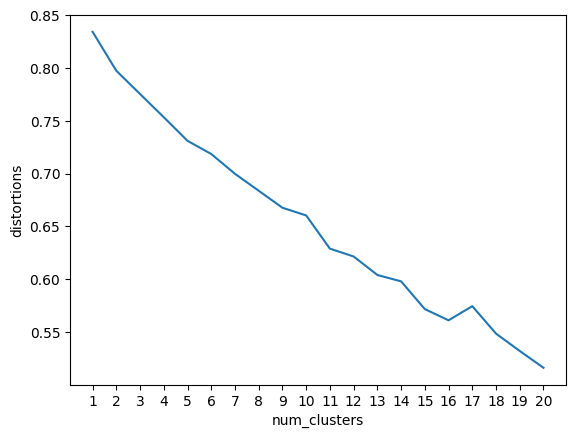

In [101]:
distortions = []
num_clusters_range = range(1, 21)

# Create a list of distortions from the kmeans method
for i in num_clusters_range:
    cluster_centers, distortion = kmeans(tfidf_matrix.todense(), i)
    distortions.append(distortion) 
    
# Create a DataFrame with two lists - number of clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters_range,
                           'distortions': distortions})
# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters_range)
plt.show()

In [ ]:
# CONCLUSION: clustering is failed
# (maybe because of noisy words)

In [356]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
# print
# print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [357]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [366]:
# cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# cluster_names = {0: 'Family, home, war', 
#                  1: 'Police, killed, murders', 
#                  2: 'Father, New York, brothers', 
#                  3: 'Dance, singing, love', 
#                  4: 'Killed, soldiers, captain'}

cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = str(i)

In [445]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=key_list)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], # color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

ValueError: All arrays must be of the same length

In [ ]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=100, stop_words='english')

# Fit the vectroizer and transform the data
tv_transformed = tv.fit_transform(speech_df['text_clean'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names()).add_prefix('TFIDF_')
print(tv_df.head())

In [ ]:
# N-grams !!!!

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate a trigram vectorizer
cv_trigram_vec = CountVectorizer(max_features=100, 
                                 stop_words='english', 
                                 ngram_range=(3,3))

# Fit and apply trigram vectorizer
cv_trigram = cv_trigram_vec.fit_transform(speech_df['text_clean'])

# Print the trigram features
print(cv_trigram_vec.get_feature_names())

# Create a DataFrame of the features
cv_tri_df = pd.DataFrame(cv_trigram.toarray(), 
                 columns=cv_trigram_vec.get_feature_names()).add_prefix('Counts_')

# Print the top 5 words in the sorted output
print(cv_tri_df.sum().sort_values(ascending=False).head())

# ideas from datacamp

In [ ]:
# NAIVE BAYES -- the best classifier for texts

# Import the necessary modules
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

# Training and testing the "fake news" model with CountVectorizer

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)


In [ ]:
# Training and testing the "fake news" model with TfidfVectorizer

# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)


In [ ]:
# basic features:
#     - number of words
#     - number of charachters
#     - average length of words

#     - number of sentences
#     - number of paragraphs
#     - number of words starting with capitals


# text features
# word features

# Create a feature char_count
tweets['char_count'] = tweets['content'].apply(len)

# Print the average character count
print(tweets['char_count'].mean())

In [ ]:
# Function that returns number of words in a string
def count_words(string):
	# Split the string into words
    words = string.split()
    
    # Return the number of words
    return len(words)

# Create a new feature word_count
ted['word_count'] = ted['transcript'].apply(count_words)

# Print the average word count of the talks
print(ted['word_count'].mean())

In [ ]:
# lemmatization = convert words into its base form

# Function to preprocess text
def preprocess(text):
  	# Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)
  
# Apply preprocess to ted['transcript']
ted['transcript'] = ted['transcript'].apply(preprocess)
print(ted['transcript'])

In [ ]:
# part-of-speech (POS) tagging


In [ ]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True, stop_words='english')

# Fit and transform X_train
X_train_bow = vectorizer.fit_transform(X_train)

# Transform X_test
X_test_bow = vectorizer.transform(X_test)

# Print shape of X_train_bow and X_test_bow
print(X_train_bow.shape)
print(X_test_bow.shape)

In [ ]:
# Create a MultinomialNB object
clf = MultinomialNB()

# Fit the classifier
clf.fit(X_train_bow, y_train)

# Measure the accuracy
accuracy = clf.score(X_test_bow, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

# Predict the sentiment of a negative review
review = "The movie was terrible. The music was underwhelming and the acting mediocre."
prediction = clf.predict(vectorizer.transform([review]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

In [ ]:
# n-grams

In [ ]:
# Generate n-grams upto n=1
vectorizer_ng1 = CountVectorizer(ngram_range=(1,1))
ng1 = vectorizer_ng1.fit_transform(corpus)

# Generate n-grams upto n=2
vectorizer_ng2 = CountVectorizer(ngram_range=(1,2))
ng2 = vectorizer_ng2.fit_transform(corpus)

# Generate n-grams upto n=3
vectorizer_ng3 = CountVectorizer(ngram_range=(1, 3))
ng3 = vectorizer_ng3.fit_transform(corpus)

# Print the number of features for each model
print("ng1, ng2 and ng3 have %i, %i and %i features respectively" % (ng1.shape[1], ng2.shape[1], ng3.shape[1]))

In [ ]:
# Define an instance of MultinomialNB 
clf_ng = MultinomialNB()

# Fit the classifier 
clf_ng.fit(X_train_ng, y_train)

# Measure the accuracy 
accuracy = clf_ng.score(X_test_ng, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

# Predict the sentiment of a negative review
review = "The movie was not good. The plot had several holes and the acting lacked panache."
prediction = clf_ng.predict(ng_vectorizer.transform([review]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

In [ ]:
start_time = time.time()
# Splitting the data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(df['review'], df['sentiment'], test_size=0.5, random_state=42, stratify=df['sentiment'])

# Generating ngrams
vectorizer = CountVectorizer(ngram_range=(1,3))
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

# Fit classifier
clf = MultinomialNB()
clf.fit(train_X, train_y)

# Print accuracy, time and number of dimensions
print("The program took %.3f seconds to complete. The accuracy on the test set is %.2f. The ngram representation had %i features." % (time.time() - start_time, clf.score(test_X, test_y), train_X.shape[1]))

In [ ]:
'''
(?)
    - to predict by program length, in what time the candidate nominates
    - to classify programs by quantitative features 
'''

In [ ]:
'''
QUESTIONS:
    - is clustering working on stemmed_words, not on original?
    - how to cut the top of noisy words?

IDEAS:
    - to cluster programs for 1st nomination and for 2+ nominations (+, but no sense)
    - to cluster programs for clusters of persons !!!
    - to add 2-tokens
'''